#Traffic Signs Classification:

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs 

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 117.80 MiB | 5.71 MiB/s, done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
 
 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline

In [4]:
np.random.seed(0)

In [5]:
# loading the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [6]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
#Checking dimensions of datasets
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [8]:
# Checking for image size and  number of images to its lables count match for training, validation and test data

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


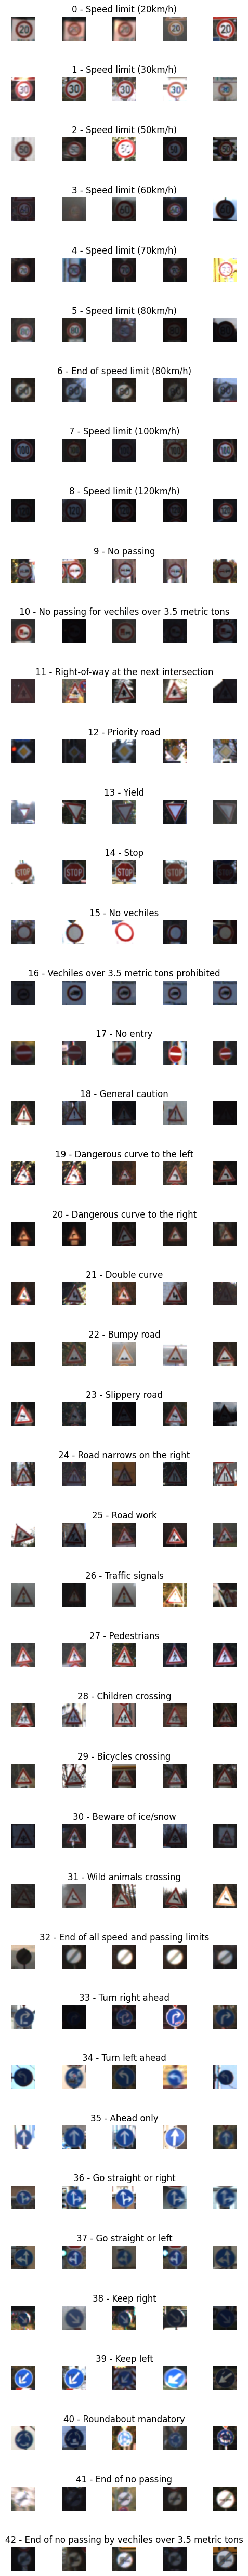

In [9]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]

cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))
print(num_of_samples)


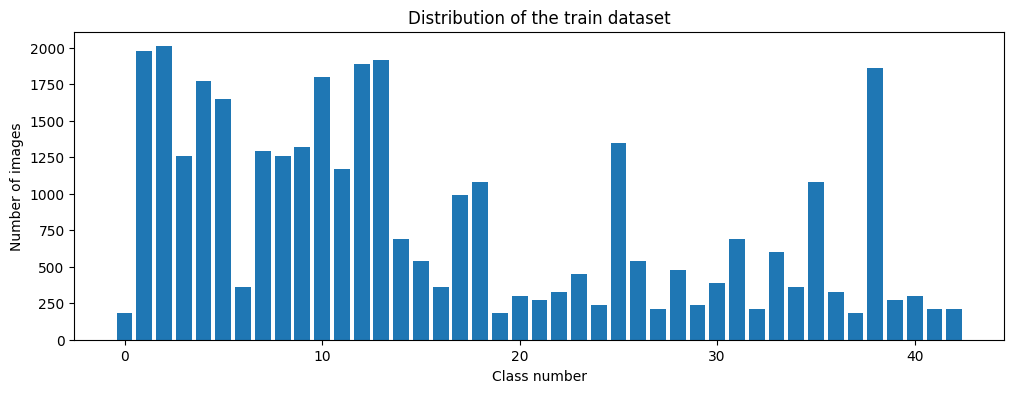

In [10]:
#showing for each sign, how many number of samples are present

plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


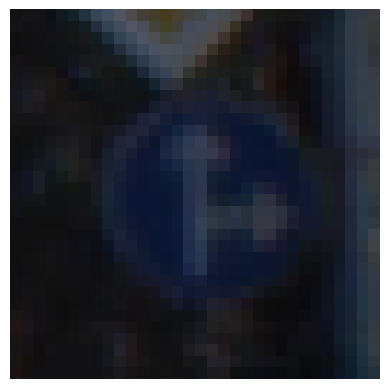

In [11]:
# checking image(randomly selected, class 1000) and its shape

import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


In [12]:
#defing function to covert image to gray scale
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


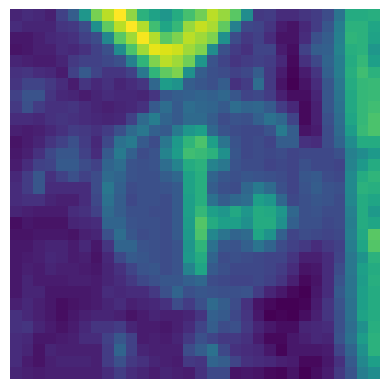

In [13]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [14]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


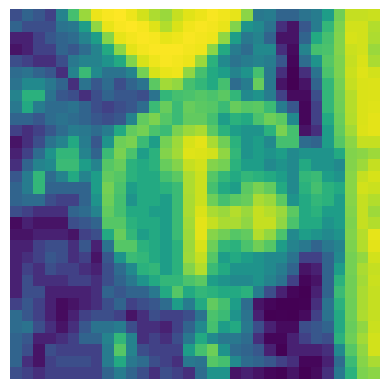

In [15]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [16]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [17]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


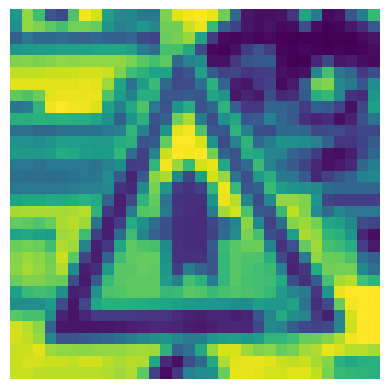

In [18]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [19]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(15, 32, 32, 1)


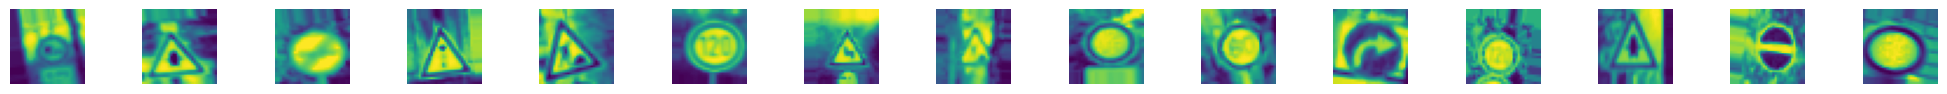

In [20]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 

#batch of 15 images are created
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

#plotting newly created images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32)) #
    axs[i].axis("off")
 
print(X_batch.shape)

In [21]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [22]:
# create model

def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(15, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [23]:
model = leNet_model()
print(model.summary())
 
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 15)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 500)               2

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/10
87/87 [==============================] - 11s 13ms/step - loss: 2.6891 - accuracy: 0.2992 - val_loss: 1.3552 - val_accuracy: 0.6039
Epoch 2/10
87/87 [==============================] - 1s 7ms/step - loss: 0.9618 - accuracy: 0.7078 - val_loss: 0.6467 - val_accuracy: 0.8057
Epoch 3/10
87/87 [==============================] - 1s 7ms/step - loss: 0.5322 - accuracy: 0.8371 - val_loss: 0.4473 - val_accuracy: 0.8630
Epoch 4/10
87/87 [==============================] - 1s 7ms/step - loss: 0.3563 - accuracy: 0.8934 - val_loss: 0.3611 - val_accuracy: 0.8964
Epoch 5/10
87/87 [==============================] - 1s 7ms/step - loss: 0.2674 - accuracy: 0.9202 - val_loss: 0.3083 - val_accuracy: 0.9048
Epoch 6/10
87/87 [==============================] - 1s 7ms/step - loss: 0.2160 - accuracy: 0.9365 - val_loss: 0.2845 - val_accuracy: 0.9113
Epoch 7/10
87/87 [==============================] - 1s 7ms/step - loss: 0.1785 - accuracy: 0.9461 - val_loss: 0.2540 - val_accuracy: 0.9188
Epoch 8/10
87

Text(0.5, 0, 'epoch')

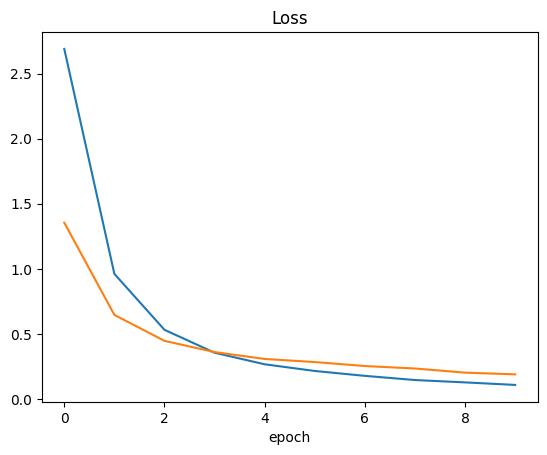

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

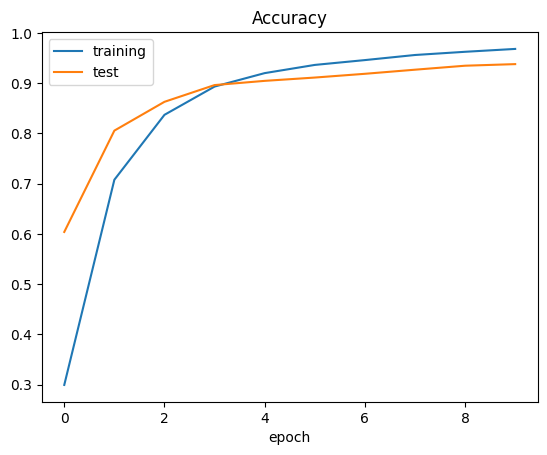

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [26]:
#Evaluating model on test data
score = model.evaluate(X_test, y_test, verbose=0)

In [27]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.333626389503479
Test accuracy: 0.9145684838294983


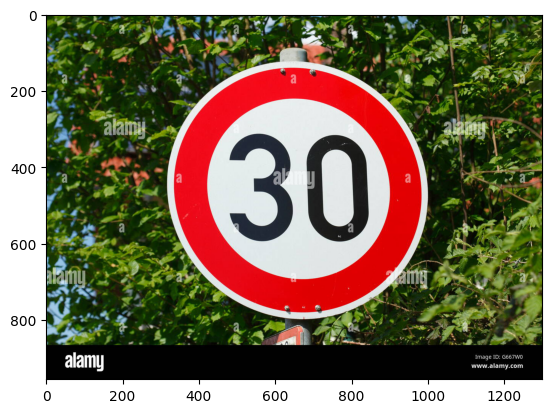

In [28]:
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


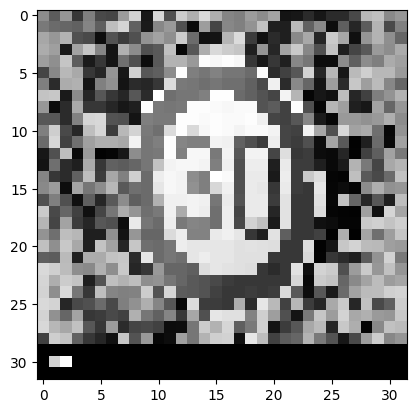

In [29]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)


In [30]:
img = img.reshape(1, 32, 32, 1)
 
predict_x=model.predict(img) 
classes_x=np.argmax(predict_x,axis=1)

print("predicted sign: "+ str(classes_x))

1/1 [==============================] - 0s 157ms/step
predicted sign: [1]


#model truly predicted the sign:
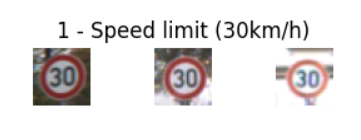